# Phase 3: Class Imbalance Analyse + Balancing

**Ziel:** Bestimmung viable Genera + Balanced Sampling für Cross-City Transfer

**Input:** Clean Feature-Daten aus Phase 2  
**Output:** Balanced Datasets pro Stadt + Reports

---

## Methodische Begründung

**Warum Class Balancing?**
- Verhindert Dominanz häufiger Klassen im Training
- Verbessert Generalisierung auf seltene Klassen
- Essentiell für faire Cross-City-Vergleiche

**Viable Genera Kriterium (≥500 Samples):**
- Transfer-Experimente benötigen jede Klasse in Train (HH+B) UND Test (Rostock)
- 500 Samples = Mindestgröße für statistische Robustheit
- Cross-City: kleinere Klassen würden in Rostock fehlen → unbalancierte Evaluation

**Sampling-Optionen:**
- **Option A (1.000/Gattung):** Konservativ, RF-fokussiert
- **Option B (1.500/Gattung):** Mehr Daten für CNN, bessere Generalisierung

---

## 1. Setup & Dependencies

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from collections import Counter

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

In [3]:
# Paths
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")
INPUT_DIR = BASE_DIR / "data" / "features"
OUTPUT_DIR = BASE_DIR / "data" / "features"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CITIES = ["Berlin", "Hamburg", "Rostock"]

print(f"✓ Base directory: {BASE_DIR}")
print(f"✓ Input directory: {INPUT_DIR}")
print(f"✓ Output directory: {OUTPUT_DIR}")

✓ Base directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit
✓ Input directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features
✓ Output directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features


---
## 2. Load Clean Feature Data

In [4]:
# Load all cities
city_data = {}

for city in CITIES:
    filepath = INPUT_DIR / f"trees_with_features_clean_{city}.gpkg"

    if not filepath.exists():
        raise FileNotFoundError(f"❌ Missing: {filepath}")

    gdf = gpd.read_file(filepath)
    city_data[city] = gdf

    print(f"✓ Loaded {city}: {len(gdf):,} trees, {gdf['genus_latin'].nunique()} genera")

print(f"\n{'='*60}")
print(f"Total trees loaded: {sum(len(gdf) for gdf in city_data.values()):,}")

✓ Loaded Berlin: 178,283 trees, 8 genera
✓ Loaded Hamburg: 46,179 trees, 8 genera
✓ Loaded Rostock: 16,140 trees, 8 genera

Total trees loaded: 240,602


---
## 3. Class Distribution Analysis

In [5]:
# Compute class counts per city
class_counts = {}

for city, gdf in city_data.items():
    counts = gdf['genus_latin'].value_counts().to_dict()
    class_counts[city] = counts

# Create combined DataFrame
all_genera = sorted(set().union(*[set(counts.keys()) for counts in class_counts.values()]))

count_df = pd.DataFrame({
    city: [class_counts[city].get(genus, 0) for genus in all_genera]
    for city in CITIES
}, index=all_genera)

count_df['Total'] = count_df.sum(axis=1)
count_df['Min_City'] = count_df[CITIES].min(axis=1)
count_df = count_df.sort_values('Total', ascending=False)

print("\n📊 Class Distribution (Top 20):")
print(count_df.head(20).to_string())


📊 Class Distribution (Top 20):
          Berlin  Hamburg  Rostock   Total  Min_City
TILIA      82145    15430     6561  104136      6561
ACER       47472     6912     3552   57936      3552
QUERCUS    27295    16710     1462   45467      1462
BETULA      7258     1911     1591   10760      1591
FRAXINUS    4946     1620      846    7412       846
POPULUS     4902      449      858    6209       449
PRUNUS      2977     1558      625    5160       625
SORBUS      1288     1589      645    3522       645


### 3.1 Visualization: Class Distribution per City

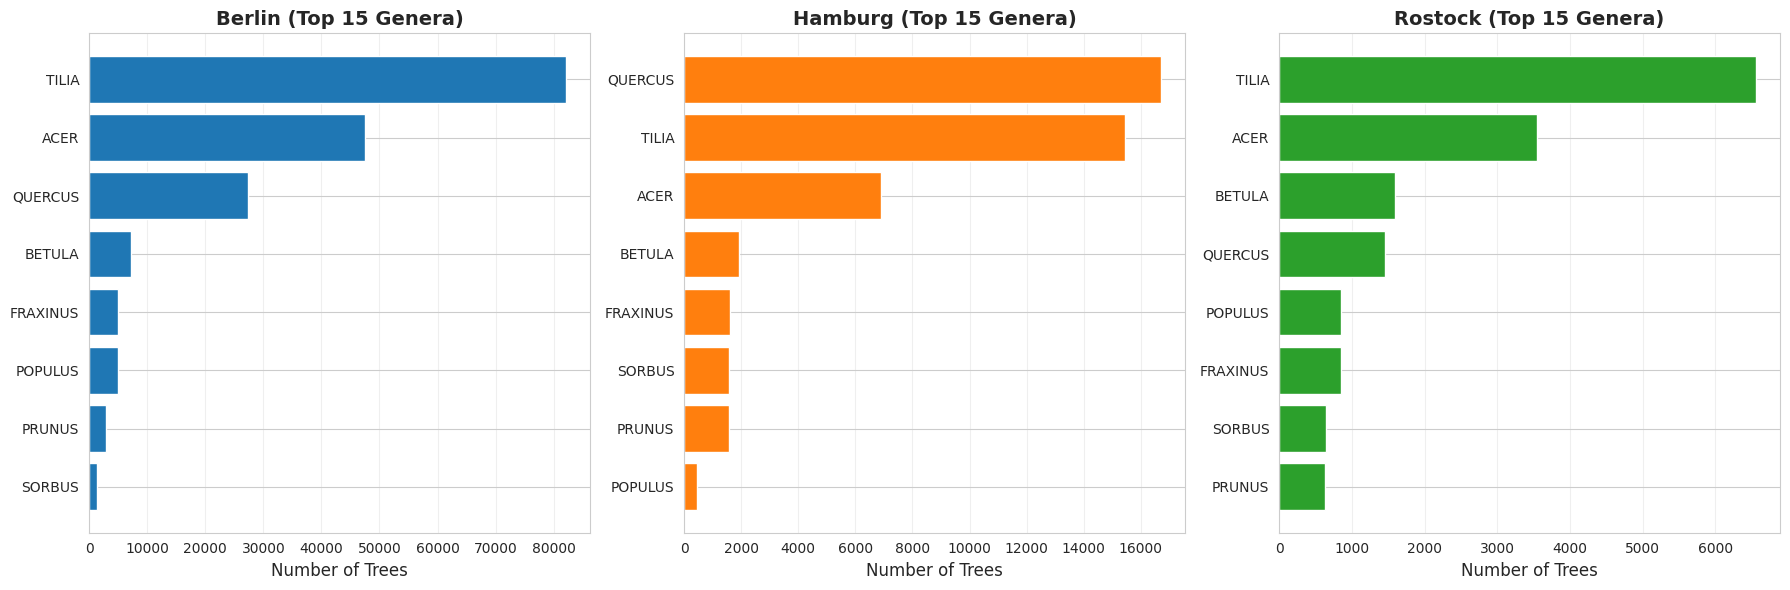

✓ Saved: class_distribution_per_city.png


In [6]:
# Plot: Top 15 Genera per City
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for i, city in enumerate(CITIES):
    top_genera = count_df.nlargest(15, city)

    axes[i].barh(top_genera.index, top_genera[city], color=f"C{i}")
    axes[i].set_xlabel("Number of Trees", fontsize=12)
    axes[i].set_title(f"{city} (Top 15 Genera)", fontsize=14, fontweight='bold')
    axes[i].invert_yaxis()
    axes[i].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "class_distribution_per_city.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: class_distribution_per_city.png")

### 3.2 Visualization: Class Imbalance Overview

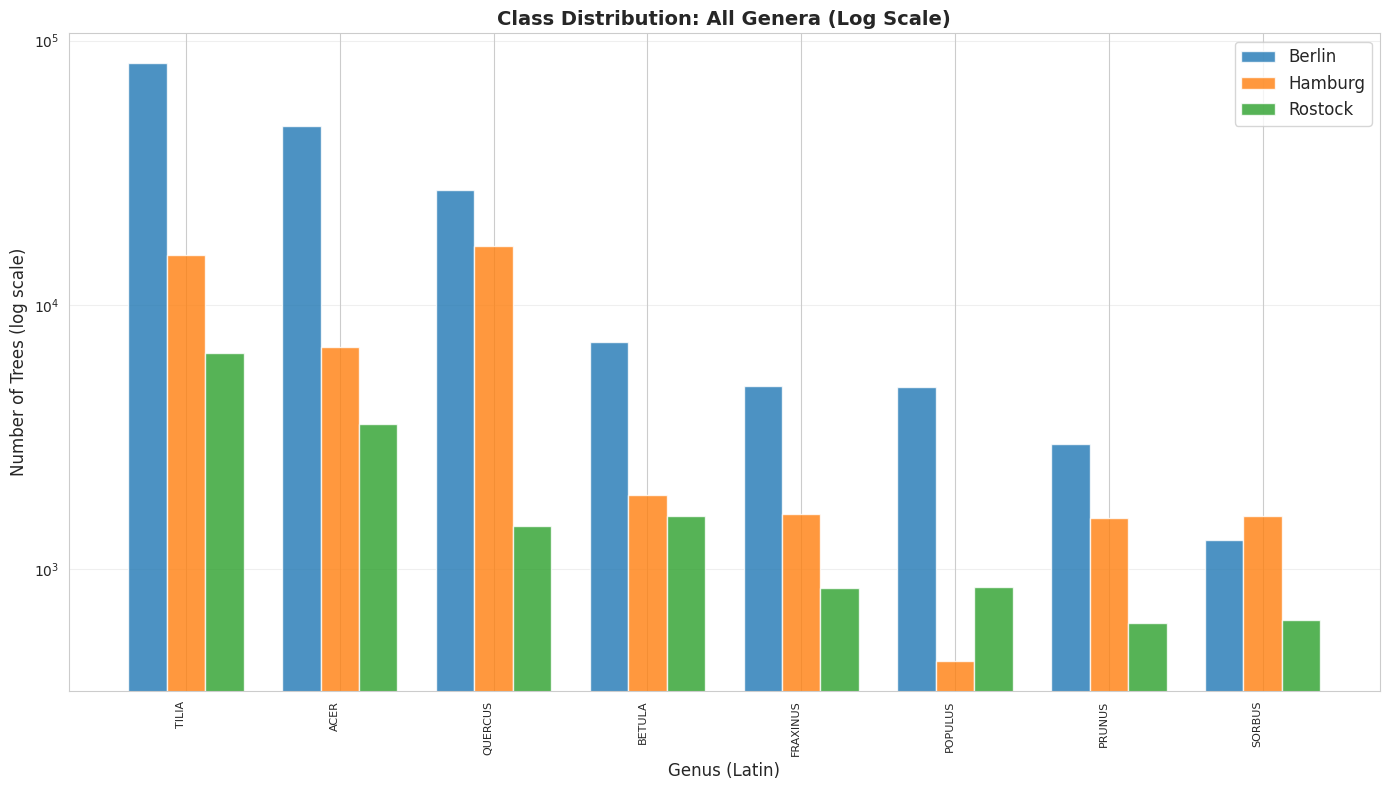

✓ Saved: class_imbalance_all_genera.png


In [7]:
# Plot: Imbalance across all cities (log scale)
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(count_df))
width = 0.25

for i, city in enumerate(CITIES):
    ax.bar(x + i*width, count_df[city], width, label=city, alpha=0.8)

ax.set_xlabel("Genus (Latin)", fontsize=12)
ax.set_ylabel("Number of Trees (log scale)", fontsize=12)
ax.set_title("Class Distribution: All Genera (Log Scale)", fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(count_df.index, rotation=90, ha='right', fontsize=8)
ax.set_yscale('log')
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "class_imbalance_all_genera.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: class_imbalance_all_genera.png")

---
## 4. Determine Viable Genera (≥500 in ALL cities)

In [8]:
# Threshold for viable genera
MIN_SAMPLES = 500

# Filter: Min_City ≥ 500
viable_genera = count_df[count_df['Min_City'] >= MIN_SAMPLES].index.tolist()

print(f"\n{'='*60}")
print(f"📌 Viable Genera (≥{MIN_SAMPLES} samples in ALL cities): {len(viable_genera)}")
print(f"{'='*60}\n")

viable_df = count_df.loc[viable_genera]
print(viable_df.to_string())

# Save viable genera list
viable_genera_data = {
    "min_samples_threshold": MIN_SAMPLES,
    "num_viable_genera": len(viable_genera),
    "viable_genera": viable_genera,
    "counts_per_city": viable_df[CITIES].to_dict(orient='index')
}

with open(OUTPUT_DIR / "viable_genera.json", 'w') as f:
    json.dump(viable_genera_data, f, indent=2)

print(f"\n✓ Saved: viable_genera.json")


📌 Viable Genera (≥500 samples in ALL cities): 7

          Berlin  Hamburg  Rostock   Total  Min_City
TILIA      82145    15430     6561  104136      6561
ACER       47472     6912     3552   57936      3552
QUERCUS    27295    16710     1462   45467      1462
BETULA      7258     1911     1591   10760      1591
FRAXINUS    4946     1620      846    7412       846
PRUNUS      2977     1558      625    5160       625
SORBUS      1288     1589      645    3522       645

✓ Saved: viable_genera.json


### 4.1 Visualization: Viable Genera

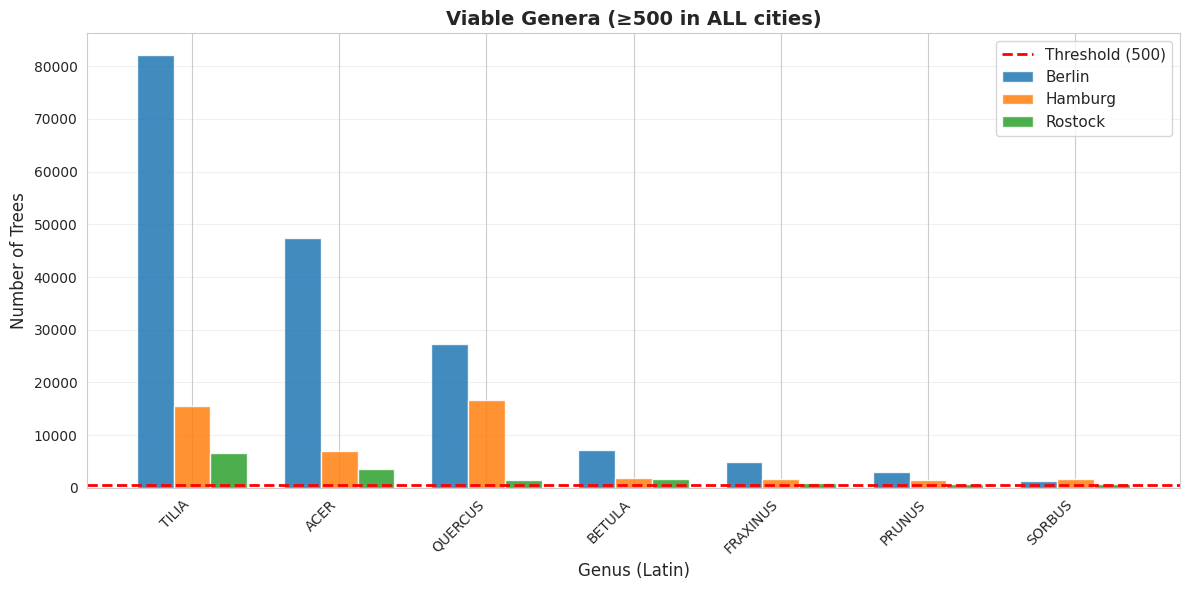

✓ Saved: viable_genera_distribution.png


In [9]:
# Plot: Viable Genera across cities
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(viable_genera))
width = 0.25

for i, city in enumerate(CITIES):
    ax.bar(x + i*width, viable_df[city], width, label=city, alpha=0.85)

ax.axhline(MIN_SAMPLES, color='red', linestyle='--', linewidth=2, label=f'Threshold ({MIN_SAMPLES})')
ax.set_xlabel("Genus (Latin)", fontsize=12)
ax.set_ylabel("Number of Trees", fontsize=12)
ax.set_title(f"Viable Genera (≥{MIN_SAMPLES} in ALL cities)", fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(viable_genera, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "viable_genera_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: viable_genera_distribution.png")

---
## 5. Balanced Sampling

**Zwei Optionen:**
- **Option A:** 1.000 Samples/Gattung (konservativ, RF-fokussiert)
- **Option B:** 1.500 Samples/Gattung (mehr Daten für CNN)

**Strategie:**
- Random Downsampling für häufige Klassen
- Behält **alle** Samples für seltene Klassen (wenn < Target)
- Räumlich stratifiziert (optional, wenn Koordinaten vorhanden)

In [10]:
def balanced_sampling(gdf, viable_genera, target_n, random_state=42):
    """
    Balanced sampling per genus.

    Args:
        gdf: GeoDataFrame with 'genus_latin' column
        viable_genera: List of genera to keep
        target_n: Target samples per genus
        random_state: Random seed for reproducibility

    Returns:
        GeoDataFrame with balanced samples
    """
    # Filter to viable genera
    gdf_viable = gdf[gdf['genus_latin'].isin(viable_genera)].copy()

    # Sample per genus
    balanced_parts = []

    for genus in viable_genera:
        genus_trees = gdf_viable[gdf_viable['genus_latin'] == genus]
        n_available = len(genus_trees)

        if n_available <= target_n:
            # Keep all (rare class)
            sampled = genus_trees
        else:
            # Random downsample
            sampled = genus_trees.sample(n=target_n, random_state=random_state)

        balanced_parts.append(sampled)

    # Concatenate
    gdf_balanced = pd.concat(balanced_parts, ignore_index=True)

    return gdf_balanced

### 5.1 Option A: 1.000 Samples/Gattung

In [ ]:
TARGET_N_A = 1000
balanced_data_A = {}

print(f"\n{'='*60}")
print(f"Option A: {TARGET_N_A} samples/genus")
print(f"{'='*60}\n")

for city, gdf in city_data.items():
    balanced = balanced_sampling(gdf, viable_genera, TARGET_N_A)
    balanced_data_A[city] = balanced

    print(f"{city}:")
    print(f"  Original: {len(gdf):,} trees")
    print(f"  Balanced: {len(balanced):,} trees ({len(balanced)/len(gdf)*100:.1f}% retained)")
    print(f"  Genera: {balanced['genus_latin'].nunique()}")
    print()

### 5.2 Option B: 1.500 Samples/Gattung

In [11]:
TARGET_N_B = 1500
balanced_data_B = {}

print(f"\n{'='*60}")
print(f"Option B: {TARGET_N_B} samples/genus")
print(f"{'='*60}\n")

for city, gdf in city_data.items():
    balanced = balanced_sampling(gdf, viable_genera, TARGET_N_B)
    balanced_data_B[city] = balanced

    print(f"{city}:")
    print(f"  Original: {len(gdf):,} trees")
    print(f"  Balanced: {len(balanced):,} trees ({len(balanced)/len(gdf)*100:.1f}% retained)")
    print(f"  Genera: {balanced['genus_latin'].nunique()}")
    print()


Option B: 1500 samples/genus

Berlin:
  Original: 178,283 trees
  Balanced: 10,288 trees (5.8% retained)
  Genera: 7

Hamburg:
  Original: 46,179 trees
  Balanced: 10,500 trees (22.7% retained)
  Genera: 7

Rostock:
  Original: 16,140 trees
  Balanced: 8,078 trees (50.0% retained)
  Genera: 7



---
## 6. Save Balanced Datasets

In [12]:
# Choose which option to save (default: Option B)
# Change to balanced_data_A if you prefer Option A
BALANCED_DATA_TO_SAVE = balanced_data_B
CHOSEN_OPTION = "B" if BALANCED_DATA_TO_SAVE is balanced_data_B else "A"
TARGET_N = TARGET_N_B if CHOSEN_OPTION == "B" else TARGET_N_A

print(f"\n📦 Saving Option {CHOSEN_OPTION} ({TARGET_N} samples/genus)...\n")

for city, gdf_balanced in BALANCED_DATA_TO_SAVE.items():
    output_path = OUTPUT_DIR / f"trees_balanced_{city}.gpkg"
    gdf_balanced.to_file(output_path, driver="GPKG")

    print(f"✓ Saved {city}: {len(gdf_balanced):,} trees → {output_path.name}")

print(f"\n{'='*60}")
print(f"Total balanced trees: {sum(len(gdf) for gdf in BALANCED_DATA_TO_SAVE.values()):,}")
print(f"{'='*60}")


📦 Saving Option B (1500 samples/genus)...

✓ Saved Berlin: 10,288 trees → trees_balanced_Berlin.gpkg
✓ Saved Hamburg: 10,500 trees → trees_balanced_Hamburg.gpkg
✓ Saved Rostock: 8,078 trees → trees_balanced_Rostock.gpkg

Total balanced trees: 28,866


---
## 7. Create Class Balance Report

In [13]:
# Compute class counts before/after balancing
report_rows = []

for genus in viable_genera:
    row = {'genus': genus}

    for city in CITIES:
        # Original counts
        orig_count = (city_data[city]['genus_latin'] == genus).sum()
        row[f"{city}_original"] = orig_count

        # Balanced counts
        balanced_count = (BALANCED_DATA_TO_SAVE[city]['genus_latin'] == genus).sum()
        row[f"{city}_balanced"] = balanced_count

        # Retention rate
        retention = (balanced_count / orig_count * 100) if orig_count > 0 else 0
        row[f"{city}_retention_pct"] = round(retention, 1)

    report_rows.append(row)

report_df = pd.DataFrame(report_rows)

# Add totals
totals = {'genus': 'TOTAL'}
for col in report_df.columns:
    if col != 'genus' and not col.endswith('_retention_pct'):
        totals[col] = report_df[col].sum()
    elif col.endswith('_retention_pct'):
        # Average retention
        totals[col] = report_df[col].mean()

report_df = pd.concat([report_df, pd.DataFrame([totals])], ignore_index=True)

# Save report
report_path = OUTPUT_DIR / "class_balance_report.csv"
report_df.to_csv(report_path, index=False)

print("\n📊 Class Balance Report:")
print(report_df.to_string(index=False))
print(f"\n✓ Saved: {report_path.name}")


📊 Class Balance Report:
   genus  Berlin_original  Berlin_balanced  Berlin_retention_pct  Hamburg_original  Hamburg_balanced  Hamburg_retention_pct  Rostock_original  Rostock_balanced  Rostock_retention_pct
   TILIA            82145             1500              1.800000             15430              1500               9.700000              6561              1500              22.900000
    ACER            47472             1500              3.200000              6912              1500              21.700000              3552              1500              42.200000
 QUERCUS            27295             1500              5.500000             16710              1500               9.000000              1462              1462             100.000000
  BETULA             7258             1500             20.700000              1911              1500              78.500000              1591              1500              94.300000
FRAXINUS             4946             1500             30.30

### 7.1 Visualization: Before/After Balance

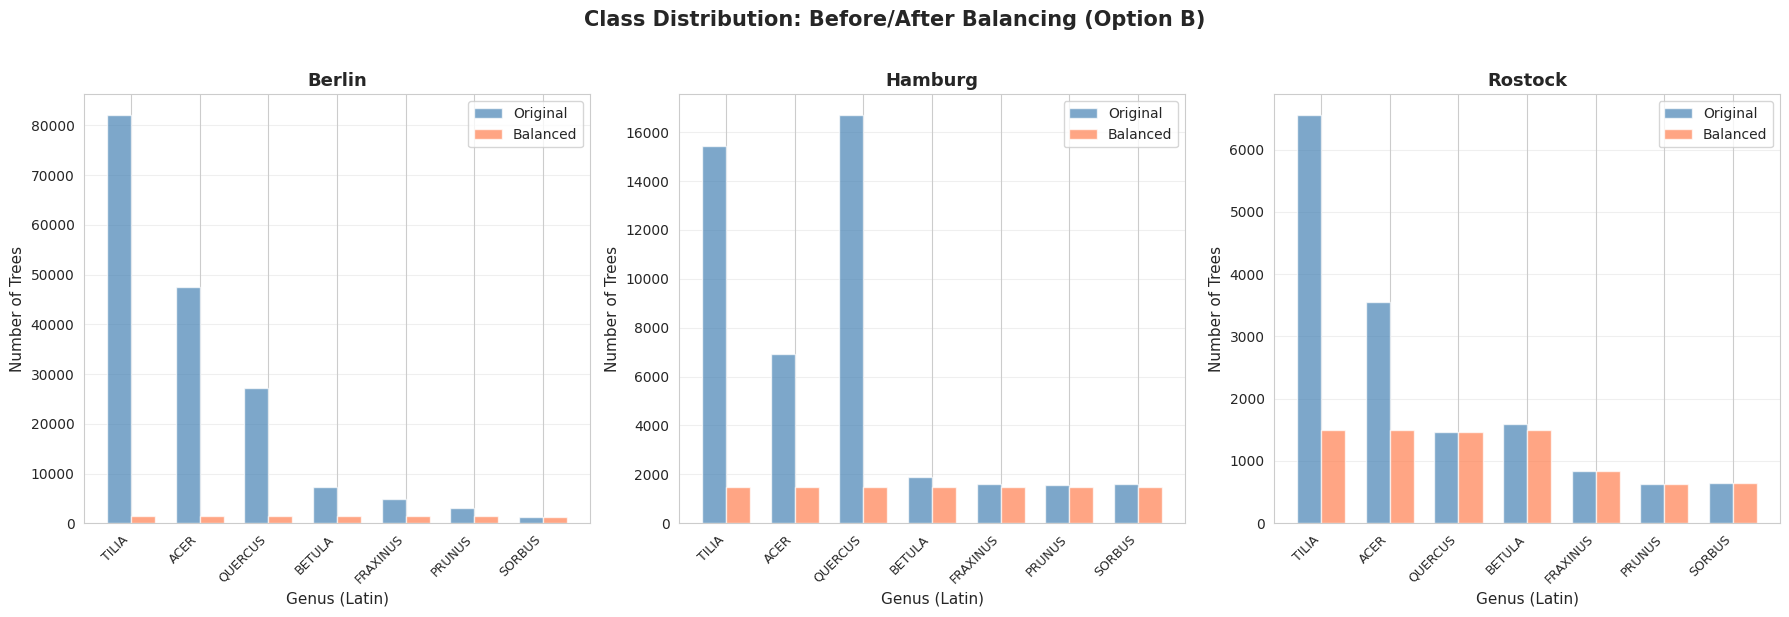

✓ Saved: class_balance_before_after.png


In [14]:
# Plot: Class distribution before/after balancing (per city)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for i, city in enumerate(CITIES):
    # Extract data for this city
    genera_plot = report_df[report_df['genus'] != 'TOTAL']['genus'].tolist()
    original = report_df[report_df['genus'] != 'TOTAL'][f'{city}_original'].tolist()
    balanced = report_df[report_df['genus'] != 'TOTAL'][f'{city}_balanced'].tolist()

    x = np.arange(len(genera_plot))
    width = 0.35

    axes[i].bar(x - width/2, original, width, label='Original', alpha=0.7, color='steelblue')
    axes[i].bar(x + width/2, balanced, width, label='Balanced', alpha=0.7, color='coral')

    axes[i].set_xlabel("Genus (Latin)", fontsize=11)
    axes[i].set_ylabel("Number of Trees", fontsize=11)
    axes[i].set_title(f"{city}", fontsize=13, fontweight='bold')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(genera_plot, rotation=45, ha='right', fontsize=9)
    axes[i].legend(fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)

plt.suptitle(f"Class Distribution: Before/After Balancing (Option {CHOSEN_OPTION})",
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "class_balance_before_after.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: class_balance_before_after.png")

---
## 8. Summary Statistics

In [15]:
summary = {
    "min_samples_threshold": MIN_SAMPLES,
    "num_viable_genera": len(viable_genera),
    "viable_genera": viable_genera,
    "balancing_option": CHOSEN_OPTION,
    "target_samples_per_genus": TARGET_N,
    "original_totals": {city: len(gdf) for city, gdf in city_data.items()},
    "balanced_totals": {city: len(gdf) for city, gdf in BALANCED_DATA_TO_SAVE.items()},
    "retention_rates_pct": {
        city: round(len(BALANCED_DATA_TO_SAVE[city]) / len(city_data[city]) * 100, 1)
        for city in CITIES
    }
}

# Save summary
summary_path = OUTPUT_DIR / "balancing_summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*60)
print("📝 FINAL SUMMARY")
print("="*60)
print(json.dumps(summary, indent=2))
print(f"\n✓ Saved: {summary_path.name}")


📝 FINAL SUMMARY
{
  "min_samples_threshold": 500,
  "num_viable_genera": 7,
  "viable_genera": [
    "TILIA",
    "ACER",
    "QUERCUS",
    "BETULA",
    "FRAXINUS",
    "PRUNUS",
    "SORBUS"
  ],
  "balancing_option": "B",
  "target_samples_per_genus": 1500,
  "original_totals": {
    "Berlin": 178283,
    "Hamburg": 46179,
    "Rostock": 16140
  },
  "balanced_totals": {
    "Berlin": 10288,
    "Hamburg": 10500,
    "Rostock": 8078
  },
  "retention_rates_pct": {
    "Berlin": 5.8,
    "Hamburg": 22.7,
    "Rostock": 50.0
  }
}

✓ Saved: balancing_summary.json


---
## ✅ Phase 3 Complete!

**Outputs Created:**
1. `trees_balanced_{city}.gpkg` (3 files) - Balanced datasets
2. `viable_genera.json` - List of viable genera + counts
3. `class_balance_report.csv` - Before/after comparison
4. `balancing_summary.json` - Summary statistics
5. Visualizations:
   - `class_distribution_per_city.png`
   - `class_imbalance_all_genera.png`
   - `viable_genera_distribution.png`
   - `class_balance_before_after.png`

**Next Steps:**
- Review viable genera (should be 6-7 classes)
- Verify balanced counts are acceptable
- Proceed to Phase 4: Train/Val/Test Split